## NLP & Binary Classification: Twitter Global Warming sentiment data
https://www.crowdflower.com/data-for-everyone/

** Dataset Information: **

- 6090 tweets for belief in the existence of global warming or climate change. “Yes” if the tweet suggests global warming is occurring, “No” if not occurring, 

** Attribute Information:**

- tweet                   
- existence             
- existence.confidence                   

** Objective of this project **

predict global warming sentiment (Yes or no) from tweets

## Data

In [1]:
options(warn=-1)
# Load Data
df_original <- read.csv('1377884570_tweet_global_warming.csv', stringsAsFactors = FALSE)

In [2]:
# Inspect Data
head(df_original,10)

tweet,existence,existence.confidence
"Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]",Yes,1.0000
Fighting poverty and global warming in Africa [link],Yes,1.0000
Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,0.8786
Carbon offsets: How a Vatican forest failed to reduce global warming [link],Yes,1.0000
URUGUAY: Tools Needed for Those Most Vulnerable to Climate Change [link],Yes,0.8087
RT @sejorg: RT @JaymiHeimbuch: Ocean Saltiness Shows Global Warming Is Intensifying Our Water Cycle [link],Yes,1.0000
Global warming evidence all around us|A message to global warming deniers and doubters: Just look around our .. [link],Yes,1.0000
Migratory Birds' New Climate Change Strategy: Stay Home [link],Yes,1.0000
Southern Africa: Competing for Limpopo Water: Climate change will bring higher temperatures to Southe... [link],Yes,1.0000
"Global warming to impact wheat, rice production in India|Ludhiana, Apr 18 : Scarcity of water will have a serious .. [link]",Yes,1.0000


In [3]:
dim(df_original)

[1] 6090    3

In [4]:
str(df_original)

'data.frame':	6090 obs. of  3 variables:
 $ tweet               : chr  "Global warming report urges governments to act|BRUSSELS, Belgium (AP) - The world faces increased hunger and .. [link]" "Fighting poverty and global warming in Africa [link]" "Carbon offsets: How a Vatican forest failed to reduce global warming [link]" "Carbon offsets: How a Vatican forest failed to reduce global warming [link]" ...
 $ existence           : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ existence.confidence: num  1 1 0.879 1 0.809 ...


In [5]:
summary(df_original)

    tweet            existence         existence.confidence
 Length:6090        Length:6090        Min.   :0.3346      
 Class :character   Class :character   1st Qu.:0.6585      
 Mode  :character   Mode  :character   Median :0.7076      
                                       Mean   :0.7945      
                                       3rd Qu.:1.0000      
                                       Max.   :1.0000      
                                       NA's   :3           

In [6]:
table(df_original$existence)


        N  N/A   No    Y  Yes 
   3 1053  469   61 2554  557 

## Exploratory Data Analysis

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


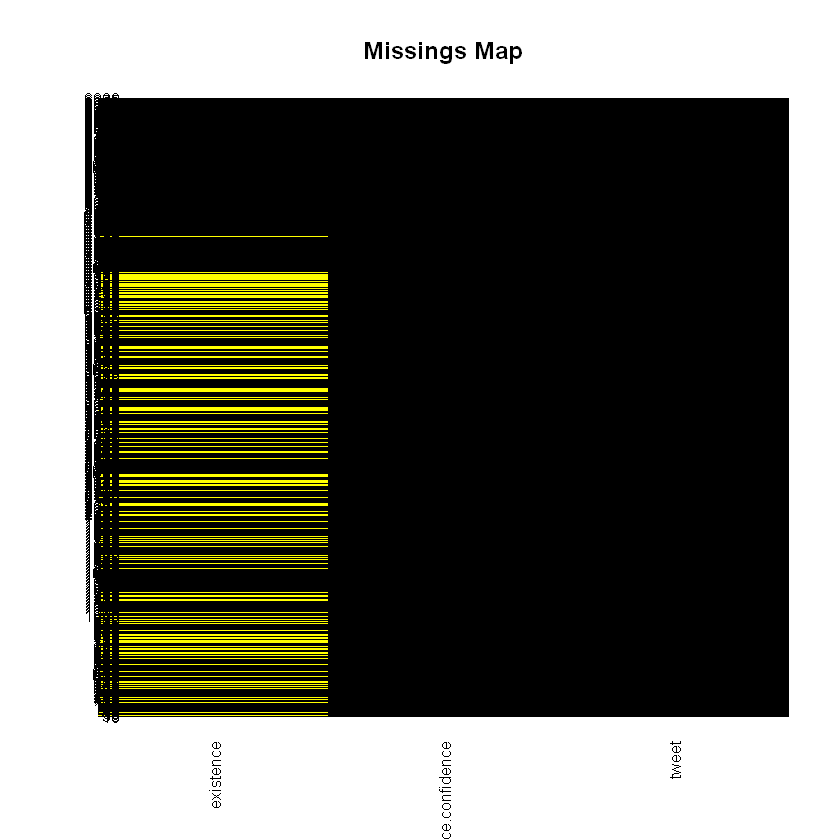

In [7]:
library(Amelia)
missmap(df_original, main='Missings Map', col=c("yellow", "black"), legend=FALSE)

In [8]:
# drop na
df_original[df_original == 'N/A']  <- NA
df_original <- df_original[complete.cases(df_original), ]

In [9]:
# Encoding categorical data
df_original[df_original == 'Yes']  <- 'Y'
df_original[df_original == 'No']  <- 'N'
df_original$label = factor(df_original$existence,
                         levels = c('Y', 'N'),
                         labels = c(1, 0))
table(df_original$label)


   1    0 
3111 1114 

In [10]:
summary(df_original)

    tweet            existence         existence.confidence label   
 Length:4225        Length:4225        Min.   :0.3434       1:3111  
 Class :character   Class :character   1st Qu.:0.6597       0:1114  
 Mode  :character   Mode  :character   Median :0.7242               
                                       Mean   :0.8060               
                                       3rd Qu.:1.0000               
                                       Max.   :1.0000               

In [11]:
# text mining
library(tm)
library(SnowballC)

clean_tweet = gsub("&amp", " ", df_original$tweet)
clean_tweet = gsub("\\[link]", " ", clean_tweet)
clean_tweet = gsub("(f|ht)tp(s?)://\\S+", " ", clean_tweet)
clean_tweet = gsub("(RT|via)((?:\\b\\W*@\\w+)+)", " ", clean_tweet)
clean_tweet = gsub("@\\w+", " ", clean_tweet)
clean_tweet = gsub("#\\w+", " ", clean_tweet)
clean_tweet = gsub("[^a-zA-Z]", " ", clean_tweet)

corpus = VCorpus(VectorSource(clean_tweet))
corpus = tm_map(corpus, content_transformer(tolower))
corpus = tm_map(corpus, removeWords, c(stopwords("english"),"will","can"))

dtm = TermDocumentMatrix(corpus)
m <- as.matrix(dtm)
v <- sort(rowSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)

Loading required package: NLP


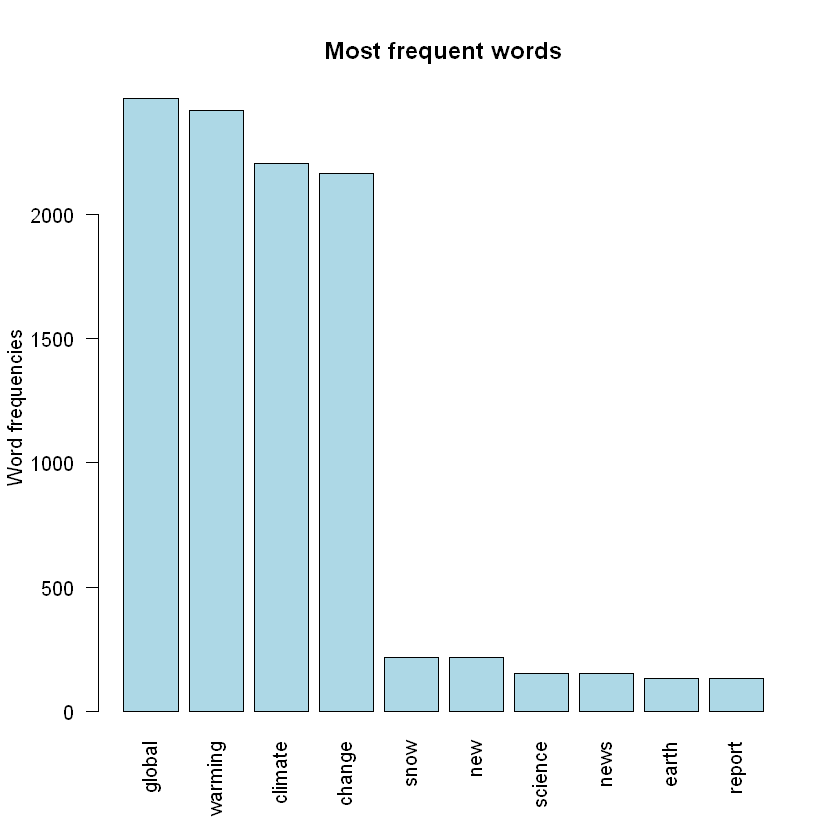

In [12]:
# top 10 spam words
barplot(d[1:10,]$freq, las = 2, names.arg = d[1:10,]$word,
        col ="lightblue", main ="Most frequent words",
        ylab = "Word frequencies")

Loading required package: RColorBrewer


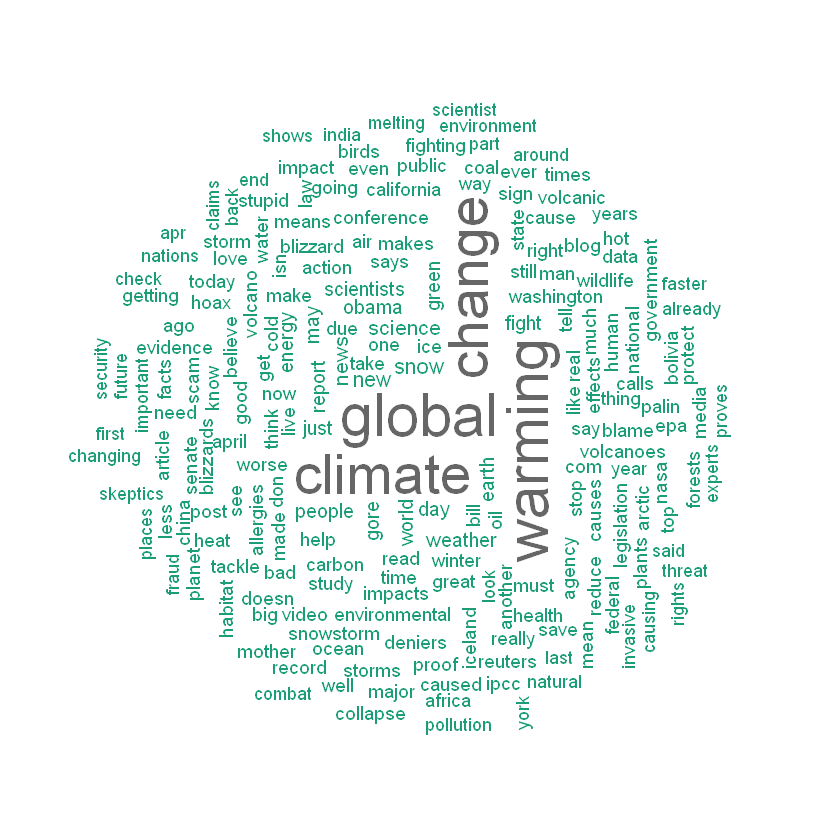

In [13]:
# wordcloud
library(wordcloud)
library(RColorBrewer)
wordcloud(words = d$word, freq = d$freq, scale=c(3,.9), min.freq = 3,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

## Data preprocessing

** Create Bag-Of-Words model **

In [56]:
corpus = tm_map(corpus, stemDocument)
corpus = tm_map(corpus, stripWhitespace)

dtm = DocumentTermMatrix(corpus)
dtm = removeSparseTerms(dtm, 0.999)
df = as.data.frame(as.matrix(dtm))
dim(df)
df$label = df_original$label
dim(df)

[1] 4225 1331

[1] 4225 1332

** Encode label **

In [59]:
df$label = factor(df$label, levels = c(0, 1))
label_col = dim(df)[2]

In [60]:
library(caTools)
library(caret)
seed = 101 #random seed for reproducibility
set.seed(seed) 

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



** Split Train Test Sets **

In [61]:
split = sample.split(df$label, SplitRatio = 0.80)
train_set = subset(df, split == TRUE)
test_set = subset(df, split == FALSE)

## Model Train /  Evaluation

In [62]:
# Fit randomForest to the Test set
library(randomForest)
model = randomForest(x = train_set[-label_col],
                     y = train_set$label,
                     ntree = 200)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



In [63]:
# Make predictions
predictions = predict(model, newdata = test_set[-label_col])
# Evaluate the results
confusionMatrix(predictions, test_set$label)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 121  57
         1 102 565
                                          
               Accuracy : 0.8118          
                 95% CI : (0.7838, 0.8377)
    No Information Rate : 0.7361          
    P-Value [Acc > NIR] : 1.464e-07       
                                          
                  Kappa : 0.4822          
 Mcnemar's Test P-Value : 0.0004841       
                                          
            Sensitivity : 0.5426          
            Specificity : 0.9084          
         Pos Pred Value : 0.6798          
         Neg Pred Value : 0.8471          
             Prevalence : 0.2639          
         Detection Rate : 0.1432          
   Detection Prevalence : 0.2107          
      Balanced Accuracy : 0.7255          
                                          
       'Positive' Class : 0               
                                          